# Task #1 

A template code for training an RBM on H$_2$ data for $r = 1.2$ is shown here. Modify this!

Imports and loading in data:

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from RBM_helper import RBM

import H2_energy_calculator

training_data = torch.from_numpy(np.loadtxt("H2_data/R_1.2_samples.txt"))
coeff = np.loadtxt("H2_data/H2_coefficients.txt")[20,:]

true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
print("H2 energy for r = 1.2: ",true_energy)

H2 energy for r = 1.2:  -1.0642022250418146


Define the RBM:

In [2]:
n_vis = 2
n_hin = 10

rbm = RBM(n_vis, n_hin)

Train the RBM:

In [3]:
epochs = 500 # number of training steps
num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy

true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
print("True energy: ",true_energy)

for e in range(1, epochs+1):
    # do one epoch of training
    rbm.train(training_data)   
 
    # now generate samples and calculate the energy
    if e % 100 == 0:
        print("\nEpoch: ", e)
        print("Sampling the RBM...")

        # For sampling the RBM, we need to do Gibbs sampling.
        # Initialize the Gibbs sampling chain with init_state as defined below.
        init_state = torch.zeros(num_samples, n_vis)
        RBM_samples = rbm.draw_samples(15, init_state)

        print("Done sampling. Calculating energy...")       
 
        energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction) 
        print("Energy from RBM samples: ", energies.item())


True energy:  -1.0642022250418146

Epoch:  100
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9876774028384503

Epoch:  200
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0352087373372594

Epoch:  300
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.049262851634507

Epoch:  400
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0643434313115818

Epoch:  500
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0680363397082435


In [4]:
from glob import glob

file_names = glob("H2_data/R_*.*_samples.txt")
coeff = np.loadtxt("H2_data/H2_coefficients.txt")

data_set = []

n_vis = 2
n_hin = 10

epochs = 500 # number of training steps
num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy

for f in file_names:
    r_data = []
    
    training_data = torch.from_numpy(np.loadtxt(f))
    r = float(f.split("_")[2])
    
    r_data.append(r)
    
    for i in range(len(coeff)):
        if coeff[i][0] == r:
            r_coeff = coeff[i,:]
    
    true_E = H2_energy_calculator.energy_from_freq(training_data, r_coeff)
    r_data.append(true_E)
    
    #print("True Energies for r = {} : {}".format(r,true_E))
    
    rbm = RBM(n_vis, n_hin)
    
    for e in range(1, epochs+1):
        rbm.train(training_data)
        
    init_state = torch.zeros(num_samples, n_vis)
    RBM_samples = rbm.draw_samples(15, init_state)
    
    energies = H2_energy_calculator.energy(RBM_samples, r_coeff, rbm.wavefunction)
    #print("RBM Engeries:", energies.item())
    
    r_data.append(energies.item())
    data_set.append(r_data)

In [10]:
data_set_1 = np.array(data_set)
data_set_1 = data_set_1[np.argsort(data_set_1[:,0])] #Sort the Array by the values of r 

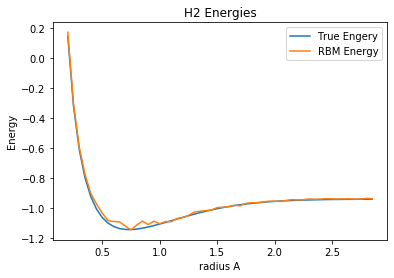

In [18]:
%matplotlib inline

r_values      = data_set_1[:,0]
true_Energies = data_set_1[:,1]
RBM_Energies  = data_set_1[:,2]

from matplotlib import pyplot as plt

plt.title("H2 Energies") 
plt.xlabel("radius A") 
plt.ylabel("Energy") 
plt.plot(r_values,true_Energies,label="True Engery") 
plt.plot(r_values,RBM_Energies,label="RBM Energy")
plt.legend(loc="upper right")
plt.show()